In [48]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torchinfo import summary
import timm

from pytorch_models_imp.visual_transformer import PatchEmbeddings, SelfAttention, TransformerBlock, VisionTransformer

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [49]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize(224),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=5)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=5)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [50]:
def imshow(img, label):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(classes[label])
    plt.show()

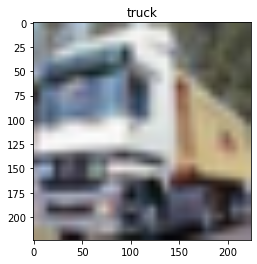

In [51]:
indx = 1
example = trainset[indx]
imshow(example[0], example[1])

In [52]:
images, labels = next(iter(trainloader))

### Images to patches

In [63]:
PATCH_SIZE = 16
EMBEDDING_SIZE = 192
DROPOUT = 0.0
HEADS = 3
FORWARD_EXPANSION = 4
NUM_LAYERS = 12

IMAGE_SIZE = example[0].shape[1]
B, C, H, W = images.shape

In [64]:
patch_embedder = PatchEmbeddings(IMAGE_SIZE, PATCH_SIZE, EMBEDDING_SIZE, DROPOUT)
print(f"NUM OF PATCHES: {patch_embedder.num_of_patches}")
out = patch_embedder(images)
assert out.shape == (B, patch_embedder.num_of_patches + 1, EMBEDDING_SIZE)  # batch, number_of_patches + 1, embed_size

NUM OF PATCHES: 196


### Self attention

In [65]:
self_attention = SelfAttention(HEADS, EMBEDDING_SIZE, DROPOUT)
attention = self_attention(out, out, out)
assert attention.shape == (B, patch_embedder.num_of_patches + 1, EMBEDDING_SIZE)

### Transformer block

In [66]:
transformer_block = TransformerBlock(HEADS, EMBEDDING_SIZE, FORWARD_EXPANSION, DROPOUT)

In [67]:
transformer_out = transformer_block(out)
assert transformer_out.shape == (B, patch_embedder.num_of_patches + 1, EMBEDDING_SIZE)

### Vision transformer

In [68]:
NUM_CLASSES = len(classes)
vision_transformer = VisionTransformer(IMAGE_SIZE, NUM_CLASSES, PATCH_SIZE, HEADS, EMBEDDING_SIZE, FORWARD_EXPANSION, NUM_LAYERS, DROPOUT)

In [69]:
summary(vision_transformer)

Layer (type:depth-idx)                   Param #
VisionTransformer                        --
├─PatchEmbeddings: 1-1                   --
│    └─Conv2d: 2-1                       147,648
│    └─Dropout: 2-2                      --
├─ModuleList: 1-2                        --
│    └─TransformerBlock: 2-3             --
│    │    └─SelfAttention: 3-1           148,224
│    │    └─LayerNorm: 3-2               384
│    │    └─LayerNorm: 3-3               384
│    │    └─Sequential: 3-4              295,872
│    │    └─Dropout: 3-5                 --
│    └─TransformerBlock: 2-4             --
│    │    └─SelfAttention: 3-6           148,224
│    │    └─LayerNorm: 3-7               384
│    │    └─LayerNorm: 3-8               384
│    │    └─Sequential: 3-9              295,872
│    │    └─Dropout: 3-10                --
│    └─TransformerBlock: 2-5             --
│    │    └─SelfAttention: 3-11          148,224
│    │    └─LayerNorm: 3-12              384
│    │    └─LayerNorm: 3-13         

In [70]:
out = vision_transformer(images)
assert out.shape == (B, NUM_CLASSES)

### TIMM model

In [79]:
from timm.data import resolve_data_config
from timm.data.transforms_factory import create_transform

model = 'vit_tiny_patch16_224'

config = resolve_data_config({}, model=model)
transform = create_transform(**config)

timm_vit = timm.create_model(model, pretrained=True, num_classes=NUM_CLASSES)

/home/evstifeev/anaconda3/envs/nn/lib/python3.8/site-packages/torchvision/transforms/transforms.py:280: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  warnings.warn(


In [81]:
config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.875}

In [80]:
transform

Compose(
    Resize(size=256, interpolation=bicubic, max_size=None, antialias=None)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=tensor([0.4850, 0.4560, 0.4060]), std=tensor([0.2290, 0.2240, 0.2250]))
)

In [73]:
5488330 - 5487946

384

In [50]:
out = timm_vit(images)

tensor([[-0.6523,  1.4096, -0.6998,  ..., -1.2547,  2.6959,  1.3969],
        [-0.8448,  0.7061, -1.3983,  ..., -0.7741, -1.4747,  1.8251],
        [-0.3161,  0.2731, -1.3113,  ..., -0.1897,  0.5453, -1.1633],
        ...,
        [ 1.0510,  3.3456,  0.2092,  ..., -0.2356,  0.9982,  0.5735],
        [ 0.0163,  0.0223, -2.3410,  ..., -1.5813,  1.8295,  1.3731],
        [-1.3123, -2.5185,  0.2349,  ...,  0.7900, -1.0725,  0.1420]],
       grad_fn=<AddmmBackward>)